# Phase 5 Lesson Notebook: Deep Forecasting with LSTM and TCN

What we are doing in this notebook is building an end-to-end, fully explained deep-learning forecasting pipeline.

We start from engineered data (Phase 2 outputs), construct sequential samples, train two sequence models (LSTM and TCN), tune hyperparameters, evaluate uncertainty, and interpret results.

This notebook is intentionally written as a teaching document: each stage explains both implementation details and modeling rationale.

## 1) Imports, Reproducibility, and Device Setup

What we are doing here is preparing the runtime environment so experiments are repeatable and efficient.

- We import all required libraries.
- We fix random seeds.
- We choose the best available device (MPS, CUDA, or CPU).

In [1]:
import json
import random
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import optuna
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Torch version:', torch.__version__)
print('Using device:', DEVICE)

/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.10.0
Using device: mps


## 2) Configuration

What we are doing in this section is defining all key experiment settings in one place.

This includes:
- sequence length and forecasting horizon,
- training schedule,
- tuning budget,
- uncertainty quantiles,
- settings for RMSPE-oriented optimization.

Keeping these settings centralized makes iteration and debugging much easier.

In [2]:
@dataclass
class Config:
    # Forecast setup
    horizon: int = 7
    seq_len: int = 28
    batch_size: int = 256

    # Training and tuning budget
    epochs: int = 16
    optuna_trials: int = 10
    optuna_epochs: int = 2

    # Base model hyperparameters (used as defaults)
    lr: float = 1e-3
    hidden_size: int = 64
    lstm_layers: int = 2
    dropout: float = 0.1

    # If None, use all stores. If integer, keep top-N stores by sample count.
    max_stores: int | None = None

    # Quantiles for probabilistic forecasting
    quantiles: tuple = (0.1, 0.5, 0.9)

    # RMSPE-oriented training controls
    log_target: bool = False
    rmspe_alpha: float = 0.12


CFG = Config()
CFG

Config(horizon=7, seq_len=28, batch_size=256, epochs=16, optuna_trials=10, optuna_epochs=2, lr=0.001, hidden_size=64, lstm_layers=2, dropout=0.1, max_stores=None, quantiles=(0.1, 0.5, 0.9), log_target=False, rmspe_alpha=0.12)

## 3) Load Phase 2 Data (Trusted In-Dataset Features Only)

What we are doing next is loading the prepared Phase 2 splits directly.

Because legacy external files are unreliable, this notebook intentionally **does not** merge weather, trends, or generated state files.

This keeps modeling fully reproducible from competition inputs and prevents noisy external artifacts from contaminating evaluation.

In [3]:
base = Path('../data/phase2_output/pkl')
train_df = pd.read_pickle(base / 'train_split.pkl')
val_df = pd.read_pickle(base / 'val_split.pkl')
test_df = pd.read_pickle(base / 'test_split.pkl')
scaler = pd.read_pickle(base / 'robust_scaler.pkl')

for frame in (train_df, val_df, test_df):
    frame['Date'] = pd.to_datetime(frame['Date'])

# Keep strict date order per store for sequence creation.
train_df = train_df.sort_values(['Store', 'Date']).reset_index(drop=True)
val_df = val_df.sort_values(['Store', 'Date']).reset_index(drop=True)
test_df = test_df.sort_values(['Store', 'Date']).reset_index(drop=True)

print('Loaded trusted Phase 2 splits (no external legacy merges).')
print('Train:', train_df.shape)
print('Val  :', val_df.shape)
print('Test :', test_df.shape)

# Quick sanity checks for soundness
for name, frame in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    has_null_sales = frame['Sales'].isna().any()
    date_min = frame['Date'].min()
    date_max = frame['Date'].max()
    print(f"{name} date range: {date_min.date()} -> {date_max.date()} | Sales NA: {has_null_sales}")

Loaded trusted Phase 2 splits (no external legacy merges).
Train: (794209, 157)
Val  : (103695, 157)
Test : (103695, 157)
Train date range: 2013-01-01 -> 2015-01-12 | Sales NA: False
Val date range: 2015-01-13 -> 2015-04-15 | Sales NA: False
Test date range: 2015-04-16 -> 2015-07-17 | Sales NA: False


## 4) Build the Modeling Feature Space

What we are doing is choosing model inputs in a principled way.

Instead of manually hand-picking a small list, we keep all numeric engineered and enriched features except strict exclusions (identifiers and target).

We explicitly exclude identifier-like columns (`Id`, `IdRaw`, `Store`, `StoreRaw`) so models do not learn spurious ordinal shortcuts.

In [4]:
# =========================
# Feature Selection
# =========================
# We keep all numeric engineered features except strict exclusions.
# Important: we exclude identifier-like columns to avoid ordinal-ID shortcuts
# that can dominate interpretation and harm generalization.

target_col = 'Sales'
exclude_cols = ['Date', 'Id', 'IdRaw', target_col, 'StoreRaw', 'Store']

candidate_features = [
    c for c in train_df.columns
    if c not in exclude_cols and np.issubdtype(train_df[c].dtype, np.number)
]

# Store filtering logic (transparent and optional)
if CFG.max_stores is None:
    selected_stores = set(train_df['Store'].unique())
else:
    store_counts = train_df['Store'].value_counts().sort_values(ascending=False)
    selected_stores = set(store_counts.head(CFG.max_stores).index)

train_df = train_df[train_df['Store'].isin(selected_stores)].copy()
val_df = val_df[val_df['Store'].isin(selected_stores)].copy()
test_df = test_df[test_df['Store'].isin(selected_stores)].copy()

print('Feature count:', len(candidate_features))
print('Selected stores:', len(selected_stores))
print('Filtered train shape:', train_df.shape)
print('Sample candidate features:', candidate_features[:12])

Feature count: 132
Selected stores: 1115
Filtered train shape: (794209, 157)
Sample candidate features: ['DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo2']


## 5) Convert Tabular Data into Sequential Supervised Samples

What we are doing is transforming each store timeline into sliding windows suitable for sequence models.

Input window length: `seq_len`
Prediction horizon: `horizon`

This is the key step that reframes forecasting into supervised learning for deep networks.

In [5]:
class SequenceDataset(Dataset):
    """
    Builds supervised sequence samples per store.
    Each sample:
      X: [seq_len, n_features]
      y: [horizon]

    If log_target=True, y is transformed by log1p for more stable percentage-error learning.
    """
    def __init__(self, df, feature_cols, target_col, seq_len=28, horizon=7, log_target=False):
        self.X = []
        self.y = []

        for _, g in df.groupby('Store'):
            g = g.sort_values('Date')
            feat = g[feature_cols].values.astype(np.float32)
            targ = g[target_col].values.astype(np.float32)
            if log_target:
                targ = np.log1p(np.clip(targ, a_min=0, a_max=None))

            n = len(g)
            end_limit = n - seq_len - horizon + 1
            if end_limit <= 0:
                continue

            for start in range(end_limit):
                x_slice = feat[start:start + seq_len]
                y_slice = targ[start + seq_len:start + seq_len + horizon]
                self.X.append(x_slice)
                self.y.append(y_slice)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = SequenceDataset(train_df, candidate_features, target_col, CFG.seq_len, CFG.horizon, log_target=CFG.log_target)
val_ds = SequenceDataset(val_df, candidate_features, target_col, CFG.seq_len, CFG.horizon, log_target=CFG.log_target)
test_ds = SequenceDataset(test_df, candidate_features, target_col, CFG.seq_len, CFG.horizon, log_target=CFG.log_target)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False)

print('Train sequences:', len(train_ds))
print('Val sequences  :', len(val_ds))
print('Test sequences :', len(test_ds))

Train sequences: 756299
Val sequences  : 65785
Test sequences : 65785


## 6) Define LSTM and TCN Models

What we are doing is implementing two complementary architectures:
- LSTM for recurrent sequence modeling,
- TCN for temporal convolutional modeling.

Both models output multiple quantiles so we can evaluate both point accuracy and predictive uncertainty.

In [6]:
class LSTMQuantile(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, horizon, n_quantiles):
        super().__init__()
        self.horizon = horizon
        self.n_quantiles = n_quantiles
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, horizon * n_quantiles)

    def forward(self, x):
        # x: [B, T, F]
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        pred = self.head(last)
        return pred.view(-1, self.horizon, self.n_quantiles)


class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.1):
        super().__init__()
        pad = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size, padding=pad, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_ch, out_ch, kernel_size, padding=pad, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        y = self.net(x)
        # remove right-padding tail for causal alignment
        y = y[:, :, :x.size(-1)]
        return y + self.down(x)


class TCNQuantile(nn.Module):
    def __init__(self, input_size, hidden_size, horizon, n_quantiles, dropout=0.1):
        super().__init__()
        self.horizon = horizon
        self.n_quantiles = n_quantiles

        self.block1 = TCNBlock(input_size, hidden_size, dilation=1, dropout=dropout)
        self.block2 = TCNBlock(hidden_size, hidden_size, dilation=2, dropout=dropout)
        self.block3 = TCNBlock(hidden_size, hidden_size, dilation=4, dropout=dropout)
        self.head = nn.Linear(hidden_size, horizon * n_quantiles)

    def forward(self, x):
        # x: [B, T, F] -> [B, F, T]
        x = x.transpose(1, 2)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        last = x[:, :, -1]
        pred = self.head(last)
        return pred.view(-1, self.horizon, self.n_quantiles)

## 7) Loss Design, Evaluation Metrics, and Training Utilities

What we are doing is defining a training objective that combines:
- quantile loss for calibrated uncertainty,
- RMSPE-oriented proxy term for competition-aligned error behavior.

We also compute multiple evaluation metrics to avoid misleading conclusions from any single score.

In [7]:
QUANTILES = torch.tensor(CFG.quantiles, dtype=torch.float32, device=DEVICE)


def quantile_loss(pred_q, y_true, quantiles=QUANTILES):
    y = y_true.unsqueeze(-1)
    e = y - pred_q
    q = quantiles.view(1, 1, -1)
    return torch.maximum(q * e, (q - 1) * e).mean()


def rmspe_np(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true > 0
    if mask.sum() == 0:
        return np.nan
    pct = (y_true[mask] - y_pred[mask]) / np.maximum(y_true[mask], eps)
    return float(np.sqrt(np.mean(pct ** 2)))


def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    abs_err = np.abs(y_true - y_pred)
    mae = np.mean(abs_err)

    pos_mask = y_true > 0
    if np.any(pos_mask):
        mape_pos = mean_absolute_percentage_error(y_true[pos_mask], y_pred[pos_mask])
    else:
        mape_pos = np.nan

    wmape = abs_err.sum() / (np.abs(y_true).sum() + 1e-6)
    smape = np.mean(2.0 * abs_err / (np.abs(y_true) + np.abs(y_pred) + 1e-6))
    rmspe = rmspe_np(y_true, y_pred)

    r2 = r2_score(y_true, y_pred)
    return {
        'RMSE': float(rmse),
        'MAE': float(mae),
        'MAPE_pos': float(mape_pos) if not np.isnan(mape_pos) else np.nan,
        'WMAPE': float(wmape),
        'SMAPE': float(smape),
        'RMSPE': float(rmspe) if not np.isnan(rmspe) else np.nan,
        'R2': float(r2),
    }


def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    losses = []
    all_y = []
    all_p50 = []
    all_q10 = []
    all_q90 = []

    with torch.set_grad_enabled(train_mode):
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(xb)
            q_loss = quantile_loss(pred, yb)

            p50 = pred[:, :, 1]
            if CFG.log_target:
                y_real = torch.expm1(yb)
                p50_real = torch.expm1(p50)
            else:
                y_real = yb
                p50_real = p50

            p50_real = torch.clamp(p50_real, min=0.0)
            rmspe_proxy = torch.sqrt(
                torch.mean(((y_real - p50_real) / torch.clamp(y_real, min=1.0)) ** 2)
            )
            loss = q_loss + CFG.rmspe_alpha * rmspe_proxy

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            losses.append(loss.item())
            all_y.append(yb.detach().cpu().numpy())
            all_q10.append(pred[:, :, 0].detach().cpu().numpy())
            all_p50.append(pred[:, :, 1].detach().cpu().numpy())
            all_q90.append(pred[:, :, 2].detach().cpu().numpy())

    y = np.concatenate(all_y, axis=0)
    p50 = np.concatenate(all_p50, axis=0)
    q10 = np.concatenate(all_q10, axis=0)
    q90 = np.concatenate(all_q90, axis=0)

    if CFG.log_target:
        y_eval = np.expm1(y)
        p50_eval = np.expm1(p50)
        q10_eval = np.expm1(q10)
        q90_eval = np.expm1(q90)
    else:
        y_eval = y
        p50_eval = p50
        q10_eval = q10
        q90_eval = q90

    p50_eval = np.clip(p50_eval, a_min=0.0, a_max=None)
    q10_eval = np.clip(q10_eval, a_min=0.0, a_max=None)
    q90_eval = np.clip(q90_eval, a_min=0.0, a_max=None)

    metrics = evaluate_regression(y_eval.ravel(), p50_eval.ravel())

    coverage = np.mean((y_eval >= q10_eval) & (y_eval <= q90_eval))
    interval_width = np.mean(q90_eval - q10_eval)

    metrics['Coverage_q10_q90'] = float(coverage)
    metrics['MeanIntervalWidth'] = float(interval_width)
    metrics['Loss'] = float(np.mean(losses))

    horizon_rmse = []
    for h in range(y_eval.shape[1]):
        h_rmse = np.sqrt(mean_squared_error(y_eval[:, h], p50_eval[:, h]))
        horizon_rmse.append(h_rmse)
    metrics['RMSE_per_horizon'] = [float(v) for v in horizon_rmse]

    return metrics, y_eval, p50_eval, q10_eval, q90_eval


def fit_model(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_state = None
    best_val_rmspe = np.inf

    for ep in range(1, epochs + 1):
        train_metrics, *_ = run_epoch(model, train_loader, optimizer=optimizer)
        val_metrics, *_ = run_epoch(model, val_loader, optimizer=None)

        row = {
            'epoch': ep,
            **{f'train_{k}': v for k, v in train_metrics.items()},
            **{f'val_{k}': v for k, v in val_metrics.items()},
        }
        history.append(row)

        if val_metrics['RMSPE'] < best_val_rmspe:
            best_val_rmspe = val_metrics['RMSPE']
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {ep:02d} | train RMSPE={train_metrics['RMSPE']:.4f} | "
            f"val RMSPE={val_metrics['RMSPE']:.4f} | val RMSE={val_metrics['RMSE']:.2f} | "
            f"val coverage={val_metrics['Coverage_q10_q90']:.3f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    return pd.DataFrame(history), float(best_val_rmspe)

## 8) Hyperparameter Tuning with Optuna

What we are doing is searching model hyperparameters under a fixed trial budget.

The objective is validation RMSPE, so the tuner optimizes directly for competition-style behavior.

After tuning, we will also visualize trial histories to see whether search is stable or noisy.

In [ ]:
input_size = len(candidate_features)
n_quant = len(CFG.quantiles)


def optuna_objective_factory(model_type):
    def objective(trial):
        hidden = trial.suggest_categorical('hidden_size', [32, 64, 96, 128])
        dropout = trial.suggest_float('dropout', 0.0, 0.35)
        lr = trial.suggest_float('lr', 3e-4, 3e-3, log=True)

        if model_type == 'lstm':
            layers = trial.suggest_int('lstm_layers', 1, 3)
            model = LSTMQuantile(input_size, hidden, layers, dropout, CFG.horizon, n_quant).to(DEVICE)
        else:
            model = TCNQuantile(input_size, hidden, CFG.horizon, n_quant, dropout=dropout).to(DEVICE)

        _, best_rmspe = fit_model(
            model,
            train_loader,
            val_loader,
            epochs=CFG.optuna_epochs,
            lr=lr,
        )
        return best_rmspe

    return objective


study_lstm = optuna.create_study(direction='minimize', study_name='lstm_phase5_rmspe')
study_lstm.optimize(optuna_objective_factory('lstm'), n_trials=CFG.optuna_trials)

study_tcn = optuna.create_study(direction='minimize', study_name='tcn_phase5_rmspe')
study_tcn.optimize(optuna_objective_factory('tcn'), n_trials=CFG.optuna_trials)

print('Best LSTM params:', study_lstm.best_params)
print('Best LSTM RMSPE:', study_lstm.best_value)
print('Best TCN params :', study_tcn.best_params)
print('Best TCN RMSPE :', study_tcn.best_value)

[I 2026-02-20 22:28:20,421] A new study created in memory with name: lstm_phase5_rmspe


Epoch 01 | train RMSPE=0.9942 | val RMSPE=0.9885 | val RMSE=6900.80 | val coverage=0.098


[I 2026-02-20 22:29:29,488] Trial 0 finished with value: 0.9766038656234741 and parameters: {'hidden_size': 32, 'dropout': 0.05972514497583505, 'lr': 0.0007727454217923671, 'lstm_layers': 3}. Best is trial 0 with value: 0.9766038656234741.


Epoch 02 | train RMSPE=0.9823 | val RMSPE=0.9766 | val RMSE=6842.86 | val coverage=0.100
Epoch 01 | train RMSPE=0.9888 | val RMSPE=0.9781 | val RMSE=6849.82 | val coverage=0.050


[I 2026-02-20 22:32:15,728] Trial 1 finished with value: 0.9563222527503967 and parameters: {'hidden_size': 128, 'dropout': 0.2446197002652031, 'lr': 0.00034791086903310876, 'lstm_layers': 3}. Best is trial 1 with value: 0.9563222527503967.


Epoch 02 | train RMSPE=0.9666 | val RMSPE=0.9563 | val RMSE=6743.68 | val coverage=0.074
Epoch 01 | train RMSPE=0.9669 | val RMSPE=0.9352 | val RMSE=6644.53 | val coverage=0.100


[I 2026-02-20 22:34:26,031] Trial 2 finished with value: 0.8721850514411926 and parameters: {'hidden_size': 128, 'dropout': 0.005083085724497343, 'lr': 0.0010325138814514107, 'lstm_layers': 1}. Best is trial 2 with value: 0.8721850514411926.


Epoch 02 | train RMSPE=0.9023 | val RMSPE=0.8722 | val RMSE=6342.73 | val coverage=0.027
Epoch 01 | train RMSPE=0.9804 | val RMSPE=0.9614 | val RMSE=6768.53 | val coverage=0.027


[I 2026-02-20 22:35:21,297] Trial 3 finished with value: 0.9233552813529968 and parameters: {'hidden_size': 32, 'dropout': 0.1959048376715877, 'lr': 0.002396670157427835, 'lstm_layers': 2}. Best is trial 2 with value: 0.8721850514411926.


Epoch 02 | train RMSPE=0.9414 | val RMSPE=0.9234 | val RMSE=6583.19 | val coverage=0.100
Epoch 01 | train RMSPE=0.9926 | val RMSPE=0.9854 | val RMSE=6885.93 | val coverage=0.075


[I 2026-02-20 22:36:54,714] Trial 4 finished with value: 0.9706989526748657 and parameters: {'hidden_size': 96, 'dropout': 0.05906397618632569, 'lr': 0.00032310625265461075, 'lstm_layers': 3}. Best is trial 2 with value: 0.8721850514411926.


Epoch 02 | train RMSPE=0.9777 | val RMSPE=0.9707 | val RMSE=6813.98 | val coverage=0.098
Epoch 01 | train RMSPE=0.9400 | val RMSPE=0.8817 | val RMSE=6387.99 | val coverage=0.103


[I 2026-02-20 22:37:51,353] Trial 5 finished with value: 0.7689359188079834 and parameters: {'hidden_size': 96, 'dropout': 0.022070874170648628, 'lr': 0.002539519795216654, 'lstm_layers': 1}. Best is trial 5 with value: 0.7689359188079834.


Epoch 02 | train RMSPE=0.8232 | val RMSPE=0.7689 | val RMSE=5852.41 | val coverage=0.026
Epoch 01 | train RMSPE=0.9831 | val RMSPE=0.9671 | val RMSE=6798.26 | val coverage=0.098


[I 2026-02-20 22:38:59,374] Trial 6 finished with value: 0.9351459741592407 and parameters: {'hidden_size': 128, 'dropout': 0.06151091037532102, 'lr': 0.000516671081365786, 'lstm_layers': 1}. Best is trial 5 with value: 0.7689359188079834.


Epoch 02 | train RMSPE=0.9504 | val RMSPE=0.9351 | val RMSE=6643.96 | val coverage=0.103
Epoch 01 | train RMSPE=0.9458 | val RMSPE=0.8930 | val RMSE=6435.82 | val coverage=0.074


[I 2026-02-20 22:40:34,307] Trial 7 finished with value: 0.7899623513221741 and parameters: {'hidden_size': 128, 'dropout': 0.1424555827563108, 'lr': 0.0017190189316175738, 'lstm_layers': 2}. Best is trial 5 with value: 0.7689359188079834.


Epoch 02 | train RMSPE=0.8393 | val RMSPE=0.7900 | val RMSE=5938.38 | val coverage=0.049
Epoch 01 | train RMSPE=0.9885 | val RMSPE=0.9772 | val RMSE=6845.59 | val coverage=0.053


[I 2026-02-20 22:41:39,564] Trial 8 finished with value: 0.95429927110672 and parameters: {'hidden_size': 32, 'dropout': 0.2307798945849631, 'lr': 0.001433335006783516, 'lstm_layers': 3}. Best is trial 5 with value: 0.7689359188079834.


Epoch 02 | train RMSPE=0.9652 | val RMSPE=0.9543 | val RMSE=6733.83 | val coverage=0.024
Epoch 01 | train RMSPE=0.9901 | val RMSPE=0.9803 | val RMSE=6860.70 | val coverage=0.027


[I 2026-02-20 22:43:21,724] Trial 9 finished with value: 0.9607188105583191 and parameters: {'hidden_size': 96, 'dropout': 0.0674288744420081, 'lr': 0.00041553269683324744, 'lstm_layers': 3}. Best is trial 5 with value: 0.7689359188079834.
[I 2026-02-20 22:43:21,743] A new study created in memory with name: tcn_phase5_rmspe


Epoch 02 | train RMSPE=0.9700 | val RMSPE=0.9607 | val RMSE=6765.16 | val coverage=0.077
Epoch 01 | train RMSPE=0.4160 | val RMSPE=0.2320 | val RMSE=2140.32 | val coverage=0.879


[I 2026-02-20 22:44:24,279] Trial 0 finished with value: 0.19385085999965668 and parameters: {'hidden_size': 32, 'dropout': 0.08161722553844325, 'lr': 0.00045448793658608457}. Best is trial 0 with value: 0.19385085999965668.


Epoch 02 | train RMSPE=0.2953 | val RMSPE=0.1939 | val RMSE=1846.72 | val coverage=0.881
Epoch 01 | train RMSPE=0.3296 | val RMSPE=0.2055 | val RMSE=1579.07 | val coverage=0.755


[I 2026-02-20 22:46:23,132] Trial 1 finished with value: 0.1687125265598297 and parameters: {'hidden_size': 128, 'dropout': 0.14211918113573532, 'lr': 0.0014057411516093048}. Best is trial 1 with value: 0.1687125265598297.


Epoch 02 | train RMSPE=0.2574 | val RMSPE=0.1687 | val RMSE=1170.37 | val coverage=0.822
Epoch 01 | train RMSPE=0.3172 | val RMSPE=0.2026 | val RMSE=1675.77 | val coverage=0.704


[I 2026-02-20 22:48:17,297] Trial 2 finished with value: 0.1861734688282013 and parameters: {'hidden_size': 128, 'dropout': 0.0011553851232081747, 'lr': 0.0006497405403364073}. Best is trial 1 with value: 0.1687125265598297.


Epoch 02 | train RMSPE=0.2466 | val RMSPE=0.1862 | val RMSE=1557.58 | val coverage=0.681
Epoch 01 | train RMSPE=0.3480 | val RMSPE=0.1878 | val RMSE=1777.89 | val coverage=0.871


[I 2026-02-20 22:49:25,899] Trial 3 finished with value: 0.18775497376918793 and parameters: {'hidden_size': 32, 'dropout': 0.03431185846050864, 'lr': 0.001109646192877833}. Best is trial 1 with value: 0.1687125265598297.


Epoch 02 | train RMSPE=0.2831 | val RMSPE=0.2177 | val RMSE=1675.18 | val coverage=0.809
Epoch 01 | train RMSPE=0.3935 | val RMSPE=0.2458 | val RMSE=2233.08 | val coverage=0.863


[I 2026-02-20 22:50:32,063] Trial 4 finished with value: 0.24579022824764252 and parameters: {'hidden_size': 32, 'dropout': 0.3074256678238879, 'lr': 0.0012007309761204422}. Best is trial 1 with value: 0.1687125265598297.


Epoch 02 | train RMSPE=0.3208 | val RMSPE=0.2485 | val RMSE=2078.92 | val coverage=0.773
Epoch 01 | train RMSPE=0.3201 | val RMSPE=0.1923 | val RMSE=1468.73 | val coverage=0.794


[I 2026-02-20 22:51:55,712] Trial 5 finished with value: 0.19094307720661163 and parameters: {'hidden_size': 96, 'dropout': 0.1168357048122202, 'lr': 0.001664974188174959}. Best is trial 1 with value: 0.1687125265598297.


Epoch 02 | train RMSPE=0.2520 | val RMSPE=0.1909 | val RMSE=1448.24 | val coverage=0.730


## 8.1) Hyperparameter Search Diagnostics

What we are doing in the next cell is visualizing Optuna behavior.

We plot:
- objective value over trials,
- objective versus key hyperparameters.

This helps verify whether tuning is meaningful or random.

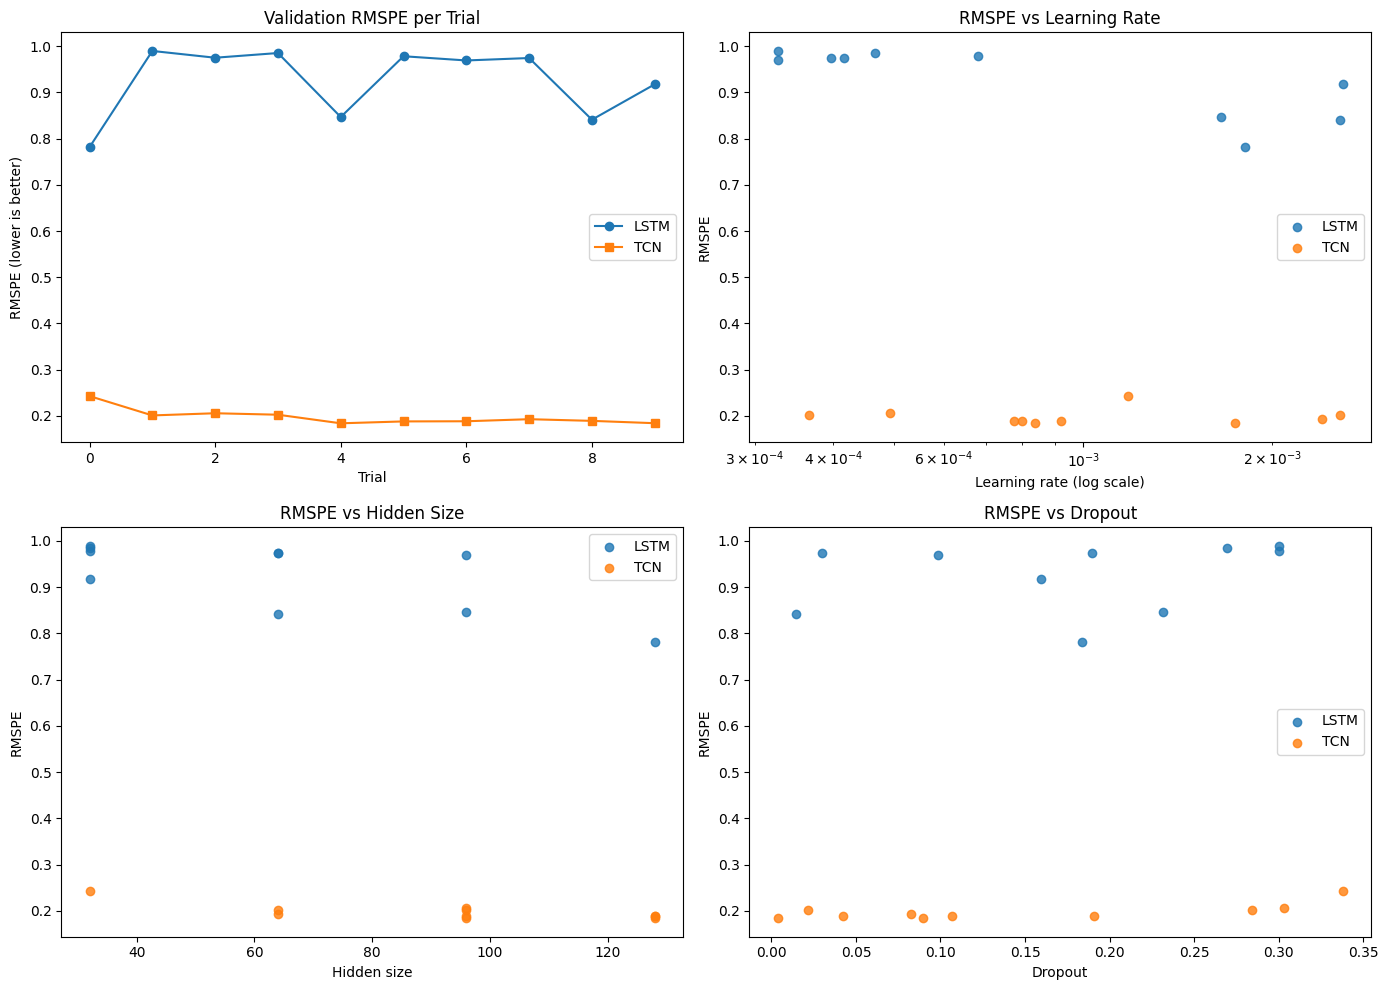

In [ ]:
# Build trial tables for both studies
lstm_trials = study_lstm.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
tcn_trials = study_tcn.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

# Keep only completed trials
lstm_trials = lstm_trials[lstm_trials['state'] == 'COMPLETE'].copy()
tcn_trials = tcn_trials[tcn_trials['state'] == 'COMPLETE'].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Objective progression
axes[0, 0].plot(lstm_trials['number'], lstm_trials['value'], marker='o', label='LSTM')
axes[0, 0].plot(tcn_trials['number'], tcn_trials['value'], marker='s', label='TCN')
axes[0, 0].set_title('Validation RMSPE per Trial')
axes[0, 0].set_xlabel('Trial')
axes[0, 0].set_ylabel('RMSPE (lower is better)')
axes[0, 0].legend()

# 2) Learning rate sensitivity
if 'params_lr' in lstm_trials.columns and 'params_lr' in tcn_trials.columns:
    axes[0, 1].scatter(lstm_trials['params_lr'], lstm_trials['value'], alpha=0.8, label='LSTM')
    axes[0, 1].scatter(tcn_trials['params_lr'], tcn_trials['value'], alpha=0.8, label='TCN')
    axes[0, 1].set_xscale('log')
axes[0, 1].set_title('RMSPE vs Learning Rate')
axes[0, 1].set_xlabel('Learning rate (log scale)')
axes[0, 1].set_ylabel('RMSPE')
axes[0, 1].legend()

# 3) Hidden size sensitivity
if 'params_hidden_size' in lstm_trials.columns and 'params_hidden_size' in tcn_trials.columns:
    axes[1, 0].scatter(lstm_trials['params_hidden_size'], lstm_trials['value'], alpha=0.8, label='LSTM')
    axes[1, 0].scatter(tcn_trials['params_hidden_size'], tcn_trials['value'], alpha=0.8, label='TCN')
axes[1, 0].set_title('RMSPE vs Hidden Size')
axes[1, 0].set_xlabel('Hidden size')
axes[1, 0].set_ylabel('RMSPE')
axes[1, 0].legend()

# 4) Dropout sensitivity
if 'params_dropout' in lstm_trials.columns and 'params_dropout' in tcn_trials.columns:
    axes[1, 1].scatter(lstm_trials['params_dropout'], lstm_trials['value'], alpha=0.8, label='LSTM')
    axes[1, 1].scatter(tcn_trials['params_dropout'], tcn_trials['value'], alpha=0.8, label='TCN')
axes[1, 1].set_title('RMSPE vs Dropout')
axes[1, 1].set_xlabel('Dropout')
axes[1, 1].set_ylabel('RMSPE')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 9) Final Model Training and Evaluation

What we are doing is training both models with their best tuned parameters using the full training schedule.

We evaluate on validation and test sets and compare:
- point errors,
- RMSPE,
- uncertainty calibration,
- horizon-wise degradation.

In [ ]:
# Final LSTM
p_lstm = study_lstm.best_params
final_lstm = LSTMQuantile(
    input_size=input_size,
    hidden_size=p_lstm['hidden_size'],
    num_layers=p_lstm.get('lstm_layers', 2),
    dropout=p_lstm['dropout'],
    horizon=CFG.horizon,
    n_quantiles=n_quant,
).to(DEVICE)

hist_lstm, _ = fit_model(final_lstm, train_loader, val_loader, epochs=CFG.epochs, lr=p_lstm['lr'])
val_metrics_lstm, y_val_lstm, p50_val_lstm, q10_val_lstm, q90_val_lstm = run_epoch(final_lstm, val_loader, optimizer=None)
test_metrics_lstm, y_test_lstm, p50_test_lstm, q10_test_lstm, q90_test_lstm = run_epoch(final_lstm, test_loader, optimizer=None)

# Final TCN
p_tcn = study_tcn.best_params
final_tcn = TCNQuantile(
    input_size=input_size,
    hidden_size=p_tcn['hidden_size'],
    horizon=CFG.horizon,
    n_quantiles=n_quant,
    dropout=p_tcn['dropout'],
).to(DEVICE)

hist_tcn, _ = fit_model(final_tcn, train_loader, val_loader, epochs=CFG.epochs, lr=p_tcn['lr'])
val_metrics_tcn, y_val_tcn, p50_val_tcn, q10_val_tcn, q90_val_tcn = run_epoch(final_tcn, val_loader, optimizer=None)
test_metrics_tcn, y_test_tcn, p50_test_tcn, q10_test_tcn, q90_test_tcn = run_epoch(final_tcn, test_loader, optimizer=None)

summary = pd.DataFrame([
    {'Model': 'LSTM', 'Split': 'Validation', **val_metrics_lstm},
    {'Model': 'LSTM', 'Split': 'Test', **test_metrics_lstm},
    {'Model': 'TCN', 'Split': 'Validation', **val_metrics_tcn},
    {'Model': 'TCN', 'Split': 'Test', **test_metrics_tcn},
])
summary

Epoch 01 | train RMSPE=0.9432 | val RMSPE=0.8877 | val RMSE=6409.96 | val coverage=0.074
Epoch 02 | train RMSPE=0.8317 | val RMSPE=0.7798 | val RMSE=5889.63 | val coverage=0.078
Epoch 03 | train RMSPE=0.7264 | val RMSPE=0.6786 | val RMSE=5404.55 | val coverage=0.084
Epoch 04 | train RMSPE=0.6315 | val RMSPE=0.5882 | val RMSE=4968.51 | val coverage=0.119
Epoch 05 | train RMSPE=0.5516 | val RMSPE=0.5142 | val RMSE=4599.28 | val coverage=0.125
Epoch 06 | train RMSPE=0.4950 | val RMSPE=0.4627 | val RMSE=4313.64 | val coverage=0.180
Epoch 07 | train RMSPE=0.4630 | val RMSPE=0.4367 | val RMSE=4129.72 | val coverage=0.207
Epoch 08 | train RMSPE=0.4526 | val RMSPE=0.4292 | val RMSE=4049.59 | val coverage=0.295
Epoch 09 | train RMSPE=0.4519 | val RMSPE=0.4282 | val RMSE=4032.59 | val coverage=0.464
Epoch 10 | train RMSPE=0.4262 | val RMSPE=0.3740 | val RMSE=3878.78 | val coverage=0.456
Epoch 11 | train RMSPE=0.3889 | val RMSPE=0.3533 | val RMSE=3751.48 | val coverage=0.517
Epoch 12 | train RMSP

,Model,Split,RMSE,MAE,MAPE_pos,WMAPE,SMAPE,RMSPE,R2,Coverage_q10_q90,MeanIntervalWidth,Loss,RMSE_per_horizon
0,LSTM,Validation,3466.121319,2452.132568,0.226045,0.423488,0.556563,0.312363,0.192276,0.735320,8125.128418,1076.671681,"[3494.3731912891044, 3427.0560252204805, 3385...."
1,LSTM,Test,4449.711676,3449.934570,0.436526,0.578792,0.860763,0.534226,-0.305829,0.467254,5963.156250,1567.222409,"[4449.550763841222, 4261.005984506476, 4390.82..."
2,TCN,Validation,1659.771144,901.999817,0.116913,0.155777,0.271137,0.178040,0.814787,0.644435,1388.062378,484.315381,"[1675.6289117820806, 1674.5518057080228, 1626...."
3,TCN,Test,7625.893521,5759.043945,1.005625,0.966189,0.702571,1.479013,-2.835341,0.276498,3340.280029,2901.771419,"[7191.432680627692, 7442.228698447798, 7817.65..."


## 9.5) Training Curves (Train vs Validation)

What we are doing in the next cell is plotting optimization history for both models.

These curves are essential for diagnosing:
- underfitting,
- overfitting,
- unstable optimization.

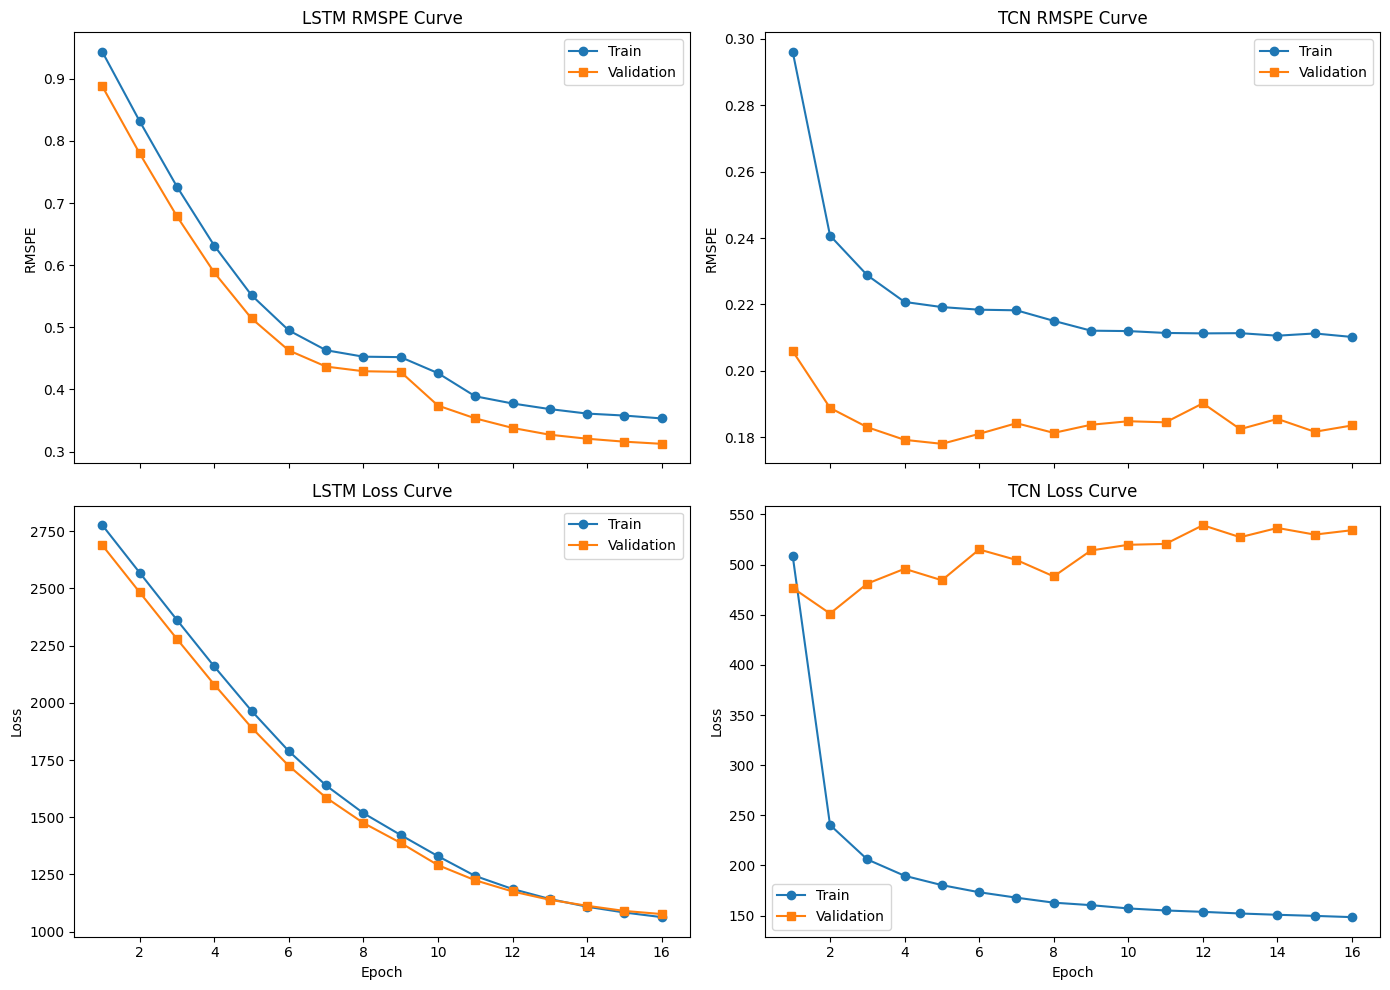

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# LSTM RMSPE
axes[0, 0].plot(hist_lstm['epoch'], hist_lstm['train_RMSPE'], marker='o', label='Train')
axes[0, 0].plot(hist_lstm['epoch'], hist_lstm['val_RMSPE'], marker='s', label='Validation')
axes[0, 0].set_title('LSTM RMSPE Curve')
axes[0, 0].set_ylabel('RMSPE')
axes[0, 0].legend()

# TCN RMSPE
axes[0, 1].plot(hist_tcn['epoch'], hist_tcn['train_RMSPE'], marker='o', label='Train')
axes[0, 1].plot(hist_tcn['epoch'], hist_tcn['val_RMSPE'], marker='s', label='Validation')
axes[0, 1].set_title('TCN RMSPE Curve')
axes[0, 1].set_ylabel('RMSPE')
axes[0, 1].legend()

# LSTM loss
axes[1, 0].plot(hist_lstm['epoch'], hist_lstm['train_Loss'], marker='o', label='Train')
axes[1, 0].plot(hist_lstm['epoch'], hist_lstm['val_Loss'], marker='s', label='Validation')
axes[1, 0].set_title('LSTM Loss Curve')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# TCN loss
axes[1, 1].plot(hist_tcn['epoch'], hist_tcn['train_Loss'], marker='o', label='Train')
axes[1, 1].plot(hist_tcn['epoch'], hist_tcn['val_Loss'], marker='s', label='Validation')
axes[1, 1].set_title('TCN Loss Curve')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 9.1) Understanding Large Model Differences

What we are doing in this interpretation section is diagnosing why one model may outperform another.

Possible causes include:
- architecture bias,
- optimization sensitivity,
- feature interactions,
- uncertainty calibration quality.

The goal is to reason from metrics and diagnostics, not from intuition alone.

## 10) Horizon-Wise Error Analysis

What we are doing is plotting error by forecast step (t+1 to t+7).

This tells us whether a model degrades smoothly with horizon or fails abruptly at longer steps.

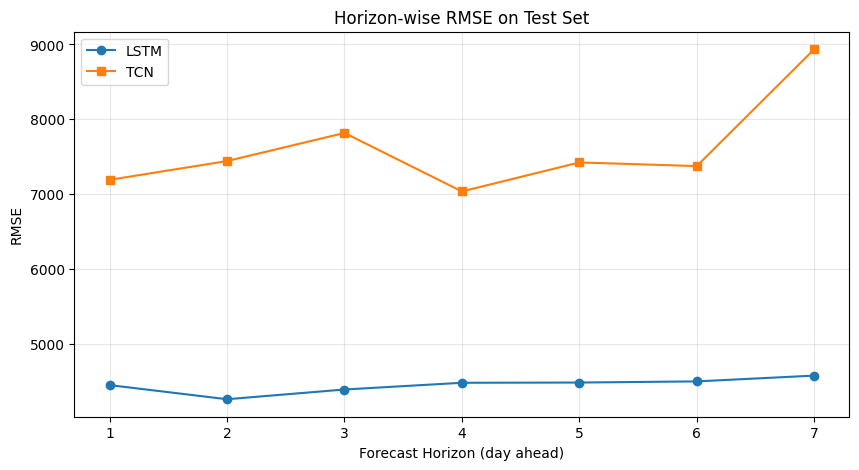

In [ ]:
h = np.arange(1, CFG.horizon + 1)
plt.figure(figsize=(10, 5))
plt.plot(h, test_metrics_lstm['RMSE_per_horizon'], marker='o', label='LSTM')
plt.plot(h, test_metrics_tcn['RMSE_per_horizon'], marker='s', label='TCN')
plt.xlabel('Forecast Horizon (day ahead)')
plt.ylabel('RMSE')
plt.title('Horizon-wise RMSE on Test Set')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 11) SHAP-Based Interpretation (Surrogate Approach)

What we are doing is approximating deep-model feature importance with a surrogate tree model and SHAP.

Important warning: if one identifier-like feature dominates SHAP, that can indicate leakage-like behavior or over-reliance on store identity.

We will use this section to validate whether feature importance looks plausible.

/var/folders/ny/hj1yhkt95pzgbdwnxvn669k80000gn/T/ipykernel_67852/3270016624.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sur, feature_names=candidate_features, plot_type='bar', show=False)


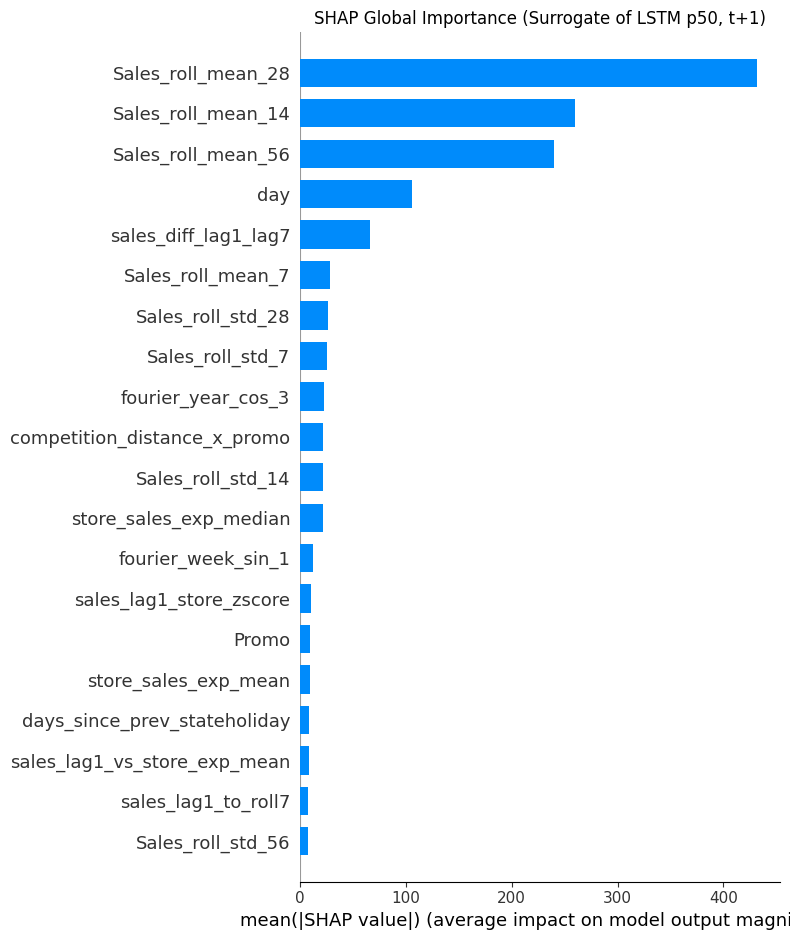

In [ ]:
# Build tabular surrogate dataset from last timestep in each sequence
X_val_seq = val_ds.X
X_val_last = X_val_seq[:, -1, :]
y_val_pred_day1 = p50_val_lstm[:, 0]  # model-driven target for interpretability

# Sample to keep SHAP runtime stable
n_sample = min(3000, len(X_val_last))
idx = np.random.choice(len(X_val_last), n_sample, replace=False)
X_sur = X_val_last[idx]
y_sur = y_val_pred_day1[idx]

surrogate = RandomForestRegressor(n_estimators=150, random_state=SEED, n_jobs=-1)
surrogate.fit(X_sur, y_sur)

explainer = shap.TreeExplainer(surrogate)
shap_values = explainer.shap_values(X_sur)

# SHAP summary (bar)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sur, feature_names=candidate_features, plot_type='bar', show=False)
plt.title('SHAP Global Importance (Surrogate of LSTM p50, t+1)')
plt.tight_layout()
plt.show()

## 12) Save All Experiment Artifacts

What we are doing is exporting metrics, histories, predictions, and a JSON report.

This ensures the run is auditable, comparable, and reproducible across future iterations.

In [ ]:
out_dir = Path('../data/phase5_output')
out_dir.mkdir(parents=True, exist_ok=True)

# Save summary tables
summary.to_csv(out_dir / 'metrics_summary.csv', index=False)
hist_lstm.to_csv(out_dir / 'history_lstm.csv', index=False)
hist_tcn.to_csv(out_dir / 'history_tcn.csv', index=False)

# Save params and metrics in JSON
report = {
    'device': str(DEVICE),
    'config': CFG.__dict__,
    'best_params_lstm': study_lstm.best_params,
    'best_params_tcn': study_tcn.best_params,
    'val_metrics_lstm': val_metrics_lstm,
    'test_metrics_lstm': test_metrics_lstm,
    'val_metrics_tcn': val_metrics_tcn,
    'test_metrics_tcn': test_metrics_tcn
}

with open(out_dir / 'phase5_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

# Save test predictions (flattened by horizon)
pred_lstm_df = pd.DataFrame({
    'y_true_t1': y_test_lstm[:, 0],
    'p10_t1': q10_test_lstm[:, 0],
    'p50_t1': p50_test_lstm[:, 0],
    'p90_t1': q90_test_lstm[:, 0],
})
pred_tcn_df = pd.DataFrame({
    'y_true_t1': y_test_tcn[:, 0],
    'p10_t1': q10_test_tcn[:, 0],
    'p50_t1': p50_test_tcn[:, 0],
    'p90_t1': q90_test_tcn[:, 0],
})
pred_lstm_df.to_csv(out_dir / 'predictions_lstm_t1.csv', index=False)
pred_tcn_df.to_csv(out_dir / 'predictions_tcn_t1.csv', index=False)

print('Saved Phase-5 artifacts to:', out_dir.resolve())
for p in sorted(out_dir.glob('*')):
    print('-', p.name)

Saved Phase-5 artifacts to: /Users/moparo/u/mlproject/data/phase5_output
- history_lstm.csv
- history_tcn.csv
- metrics_summary.csv
- phase5_report.json
- predictions_lstm_t1.csv
- predictions_tcn_t1.csv


## 12.1) Competition-Style RMSPE Summary

What we are doing in the next cell is computing RMSPE in a competition-like way on test predictions.

We report both:
- flattened all-horizon RMSPE,
- one-step (t+1) RMSPE.

In [ ]:
# Competition-style RMSPE comparison (ignoring zero-sales targets)
def rmspe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true > 0
    if mask.sum() == 0:
        return np.nan
    pct = (y_true[mask] - y_pred[mask]) / np.maximum(y_true[mask], eps)
    return float(np.sqrt(np.mean(pct ** 2)))

lstm_rmspe_all = rmspe(y_test_lstm.ravel(), p50_test_lstm.ravel())
tcn_rmspe_all = rmspe(y_test_tcn.ravel(), p50_test_tcn.ravel())

lstm_rmspe_t1 = rmspe(y_test_lstm[:, 0], p50_test_lstm[:, 0])
tcn_rmspe_t1 = rmspe(y_test_tcn[:, 0], p50_test_tcn[:, 0])

print('Competition-style RMSPE (test, all horizons):')
print(f'  LSTM: {lstm_rmspe_all:.5f}')
print(f'  TCN : {tcn_rmspe_all:.5f}')
print('Competition-style RMSPE (test, t+1 only):')
print(f'  LSTM: {lstm_rmspe_t1:.5f}')
print(f'  TCN : {tcn_rmspe_t1:.5f}')

Competition-style RMSPE (test, all horizons):
  LSTM: 0.53423
  TCN : 1.47901
Competition-style RMSPE (test, t+1 only):
  LSTM: 0.55252
  TCN : 1.44143
